<a href="https://colab.research.google.com/github/JTT94/neural_processes/blob/master/notebooks/np.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meta-Learning

In [0]:
from IPython.display import Image

import sys

!test -d neural_processes || git clone https://github.com/JTT94/neural_processes.git
if not 'neural_processes' in sys.path:
  sys.path.append('neural_processes')
  

## Introduction

Intro stuff

# Theory

Neural networks are used to parameterise a single function (task) using a large number of training points, and most of the work is done at the training stage. Network outputs cannot be updated after training, meaning that it takes a lot of effort to re-train the NN for other tasks. Meta-learning addresses this limitation, through constructing methods for "learning to learn", i.e. optimising the learning process so that it can adapt quickly to learn new tasks.

## Neural Processes

### Neural Processes (NPs)

Neural Processes (NPs) are a class of probabilistic models based on Neural Networks (NNs), which can represent distributions over stochastic processes. They combine the advantages of NNs, being computationally efficient, with those of Gaussian Processes (GPs), being data-efficient and flexible. The result can be seen as a prior over functions (or tasks). 

Given an observation set $O = \{(x_i, y_i)\}_{i=1}^n$, these are used to form a set of context points $C = \{(x_j, y_j), j = 1, ..., m\}$ and a set of unseen target points $T = \{ (x^*_k, y^*_k), k = m+1, ..., n \}$. Given the context set and the $x^*_k$, the goal is to predict the function values $y^*_k$. Note that this differs from the usual split into training and test data, as both sets are used to train the NP. The (probabilistic) loss function is defined over the target set; the loss is computed and the NP is trained using back-propagation. 

NPs can be seen as a latent variable model which captures the hidden distributions among the task that we trained on. We denote these probabilistic latent representations by $z$ and their distribution by $p(z|x_{1:m}, y_{1:m})$. In practice this is unknown so we have to approximate using Gaussian distribution just like in the case of variational autoencoders. 

The whole concept will be best explained along with the follow figure from [Kaspar Martens's tutorial on Neural Processes](https://kasparmartens.rbind.io/post/np/),

![](https://raw.githubusercontent.com/kasparmartens/NeuralProcesses/master/fig/schema2.png)

Starting from the first step of the algorthim, we have:

1. The context set $\{x_i, y_i\}_{i=1}^m$ is first mapped through the R-encoder $h$, usually a neural network, to obtain the latent representations $\{r_i\}_{i=1}^m$. 

2. These latent representations are then aggregated in a permutation invariant manner, usually done by taking averages, to produce a single vector $r$.

3. This $r$ is then passed to two other neural networks to produce the parameters $\mu_z$ and $\sigma_z$ of the approximated gaussian distribution of $z$.

4. Finally, we sample a $z$ from the distribution and concantanate it with the input target $x^{*}$. This is then passed to the decoder neural network $g$ to obtain a prediction of $y^*$.

The optimisation criterion for this layout is the evidencce lower-bound of posterior predictive density, 
$$
\log p(y^*_{m+1:n}|x_{1:m}, y_{1:m}) \geq \mathbb{E}_{q(z|x_{1:n}, y_{1:n})} \bigg[ \sum_{i=m+1}^n \log p(y_i|z, x_i) + \log \frac{q(z|x_{1:m}, y_{1:m})}{q(z|x_{1:n}, y_{1:n})}\bigg]
$$
which is an approximated version as we have no access to $p(z|x_{1:m}, y_{1:m})$.

-----------------------

### We will now demonstrate this idea on a simple 1-D regression case.

Let's first sample a single function from a GP with the following kernel,

$$
k(x, x') = \sigma\exp\big(-\frac{||x-x'||^2}{2l^2}\big)
$$

where we set the noise $\sigma$ and the lengthscale $l$ to be 1,



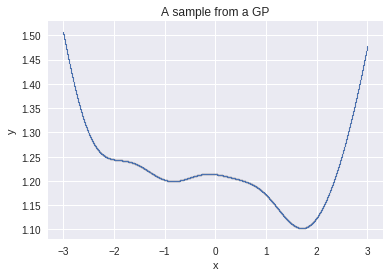

Picking different number of points from the function to run the NP alogorithm


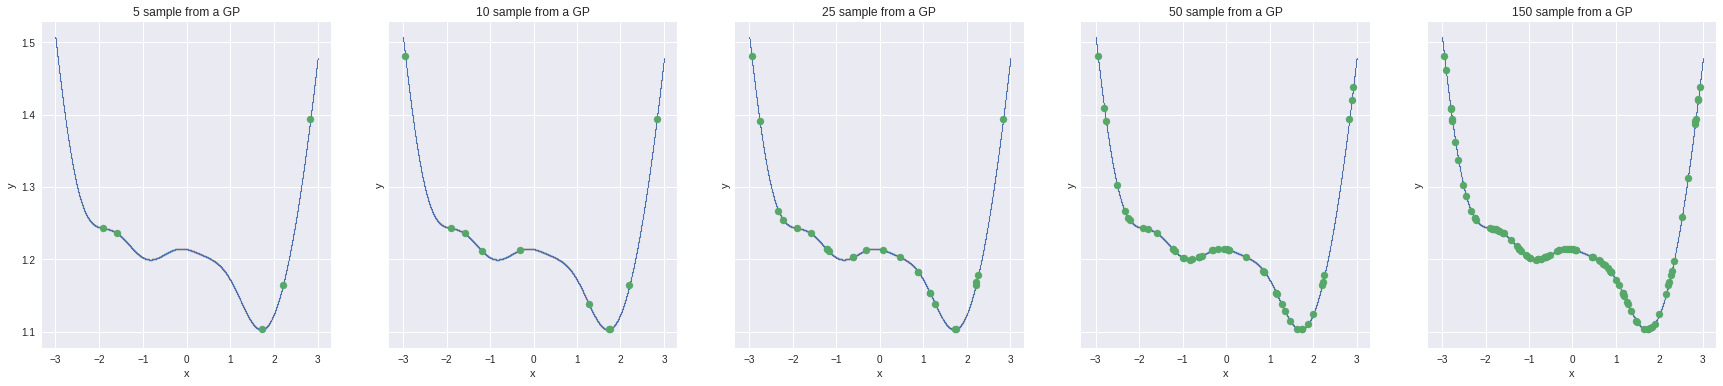

In [0]:
# Load the image
display(Image('../1sample_GP.png'))
print("Picking different number of points from the function to run the NP alogorithm")
display(Image('../context_points.png', width = 1200))


We will now run the NP algorithm to the above datasets. We will set both the dimension of $r$ and $z$ to be 1. From left to right, we see the progression of the algorithm against the number of iterations.  

For 5 data points


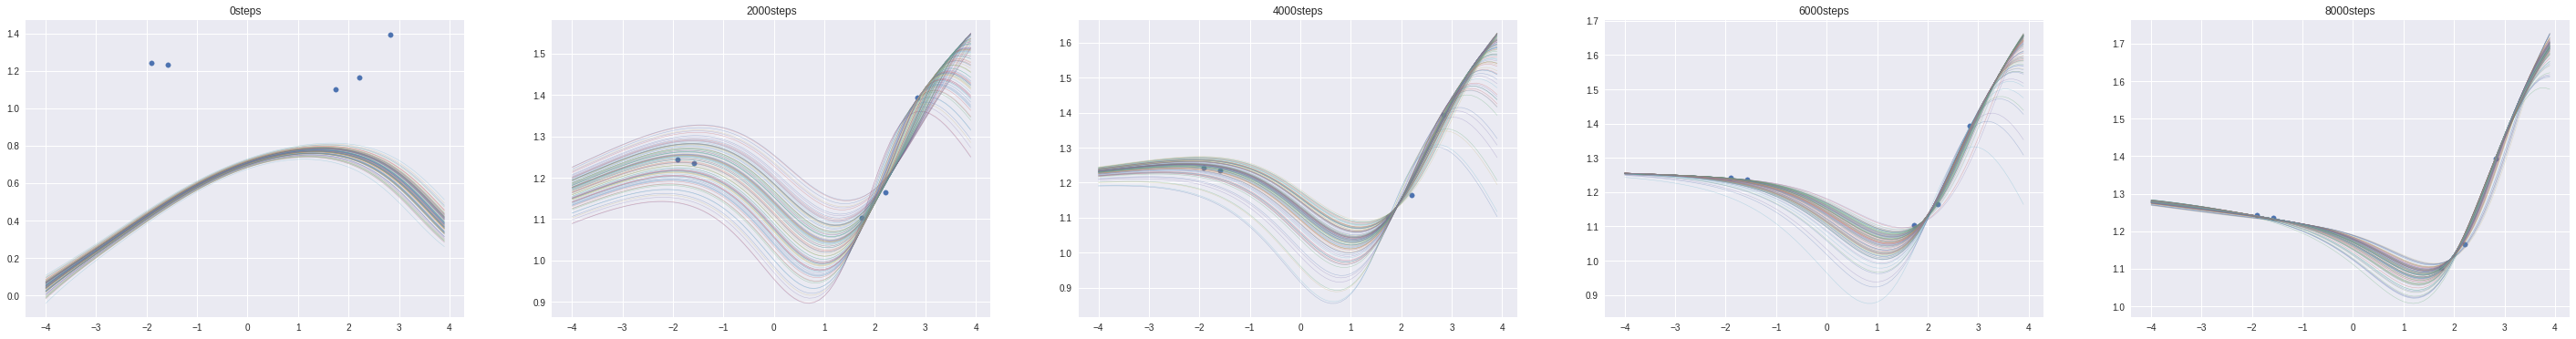

For 10 data points


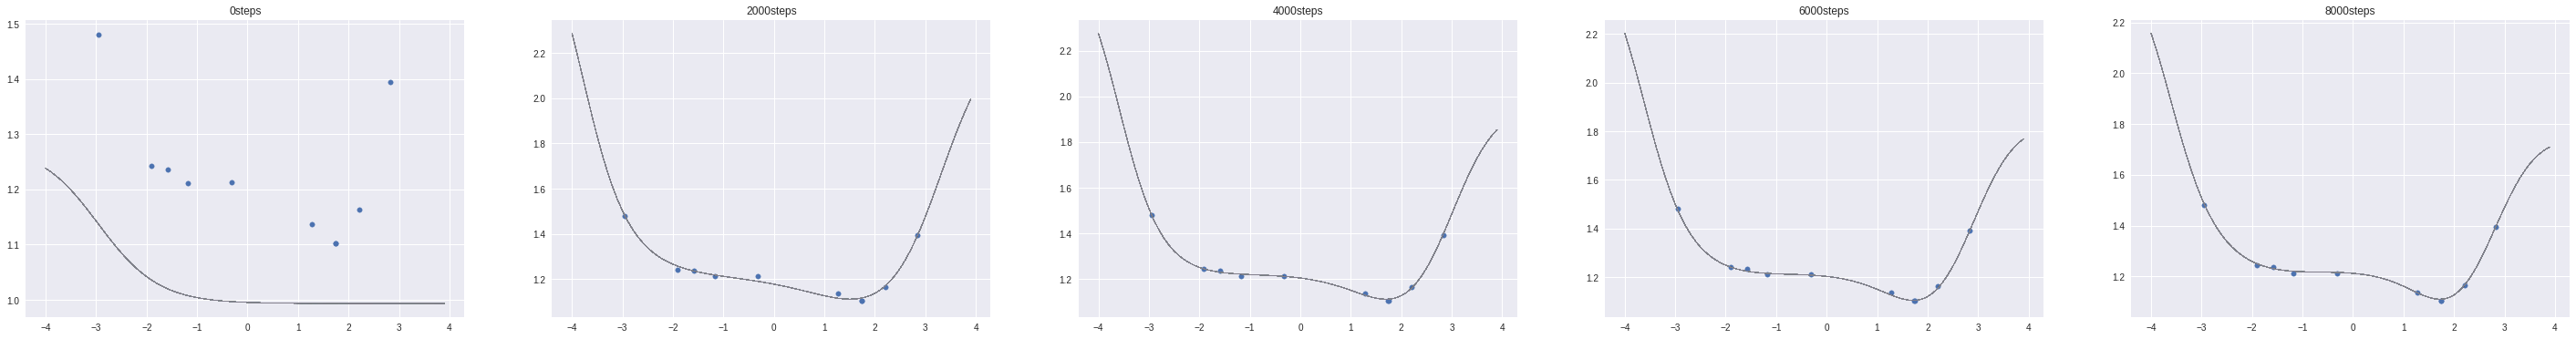

For 25 data points


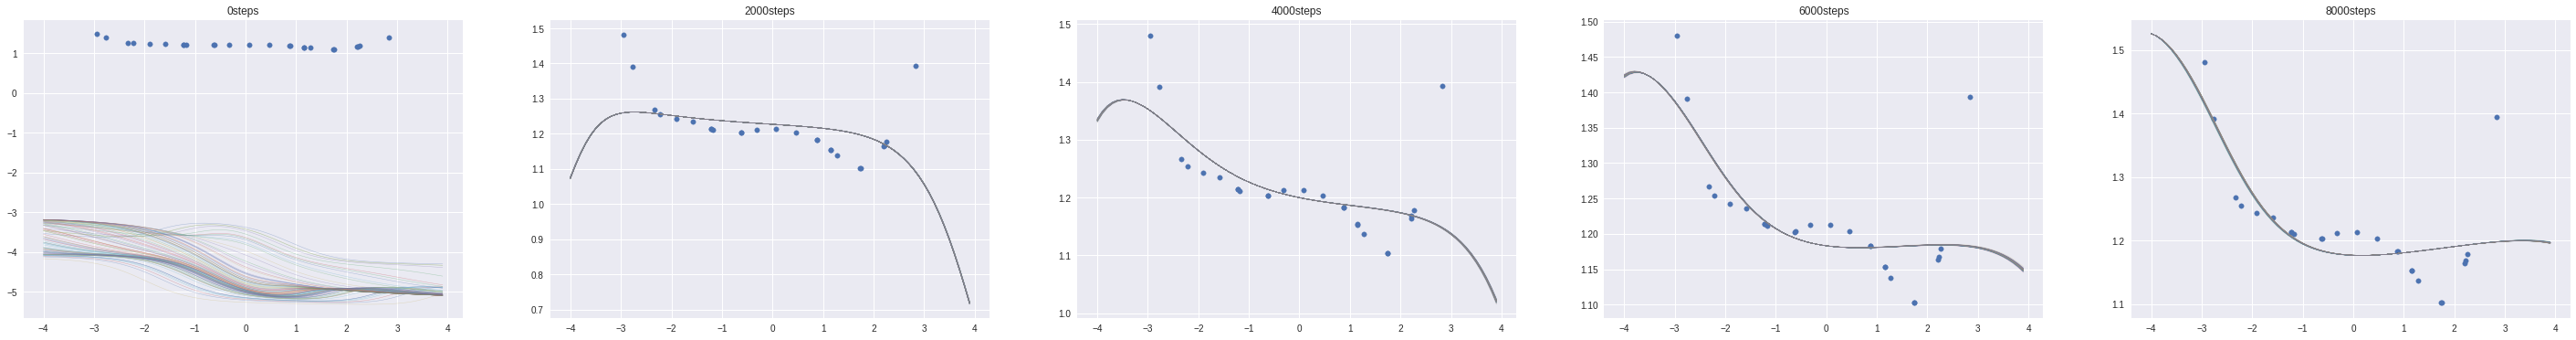

For 50 data points


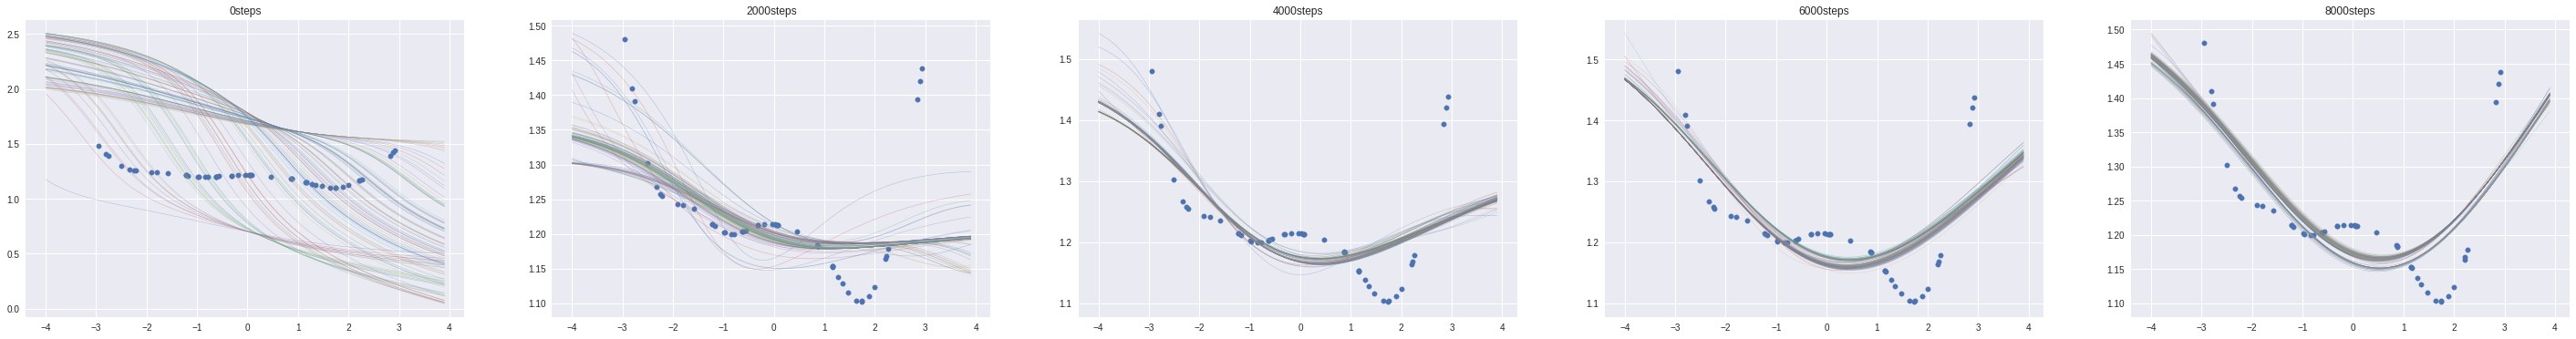

For 150 data points


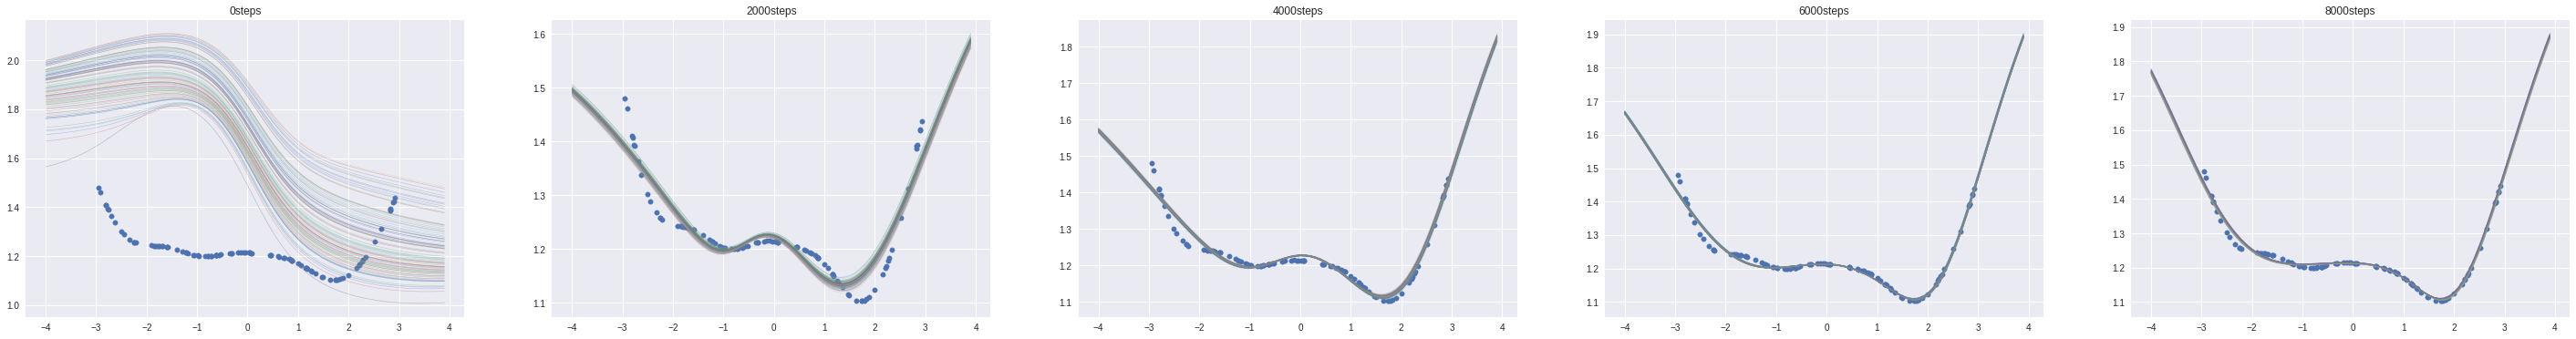

In [0]:
print("For 5 data points")
display(Image("../5 samples.png", width=1200, height=200))
print("For 10 data points")
display(Image("../10 samples.png", width=1200, height=200))
print("For 25 data points")
display(Image("../25.png", width=1200, height=200))
print("For 50 data points")
display(Image("../50 samples.png", width=1200, height=200))
print("For 150 data points")
display(Image("../150 samples.png", width=1200, height=200))


We some how the GP-alike samples behaved in the initial run and how they become more certain about the prediction when the iteration increases. 

### Conditional Neural Processes (CNPs)

Conditional Neural Processes (CNPs) are similar to NPs, but lack the global latent variable $z$, and thus cannot use the same context data to obtain different sampled functions. There is a deterministic connection between the context and target sets, so the resulting uncertainty cannot be modelled in the same way as with NPs. 

CNPs give a conditional distribution over functions $f \sim P$, given a set of observations. They are trained by taking a set $O$ of $n$ observations, and a random subset $O_N$ of N elements, $N \sim \text{Unif}(0, n-1)$. Then predictions of $O$ are made, based on $O_N$, and using gradient steps the conditional likelihood of the targets given $O_N$ is maximised. 

The architecture of CNPs is similar to that of NPs:

1. The observation set $O$ is first mapped through the R-encoder $h$, usually a neural network, to obtain the latent representations $\{r_i\}_{i=1}^n$. 

2. These latent representations are then aggregated in a permutation invariant manner, usually done by taking averages, to produce a single vector $r$.

3. $r$ and  $x^*$ are then passed to the decoder neural network $g$ to obtain predictions of $y^*$.

###Attentive Neural Processes (ANPs)

*** Alan Chau will add in some comments later ***

##Model-Agnostic Meta-Learning (MAML)

# Experiments

### Sine waves

### Gaussian Processes

In this experiment, we will test how NP can be used to learn the distribution of tasks, where each task is a function sampled from the same GP with a Matern52 kernel with variance 2, length scale 1.5.

We sampled 20 such functions and for each task we sample 3 points randomly from it. The aim of the this experiment is to see whether the NP trained along with these 20 tasks can learn the common structure underlying these tasks (the kernel).

Here are the 20 samples from a Gaussian Process


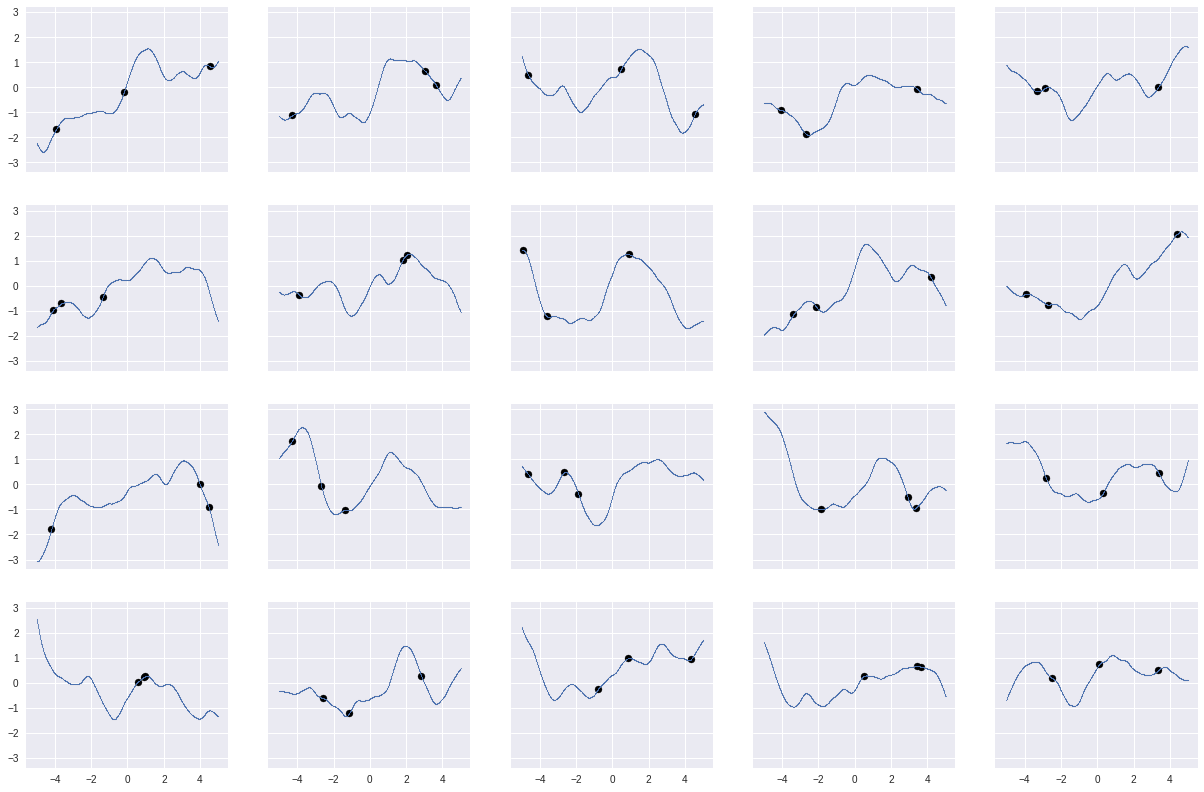

In [0]:
print("Here are the 20 samples from a Gaussian Process")
Image("../GP_exp1.png", width=1000)

We will be using a NP with the following setup,

* $h$, $g$ are both a 3 layer NN 
* The Z-encoder are both 1 layer NN

We willl also fit a Gaussian processes (with RBF + white noise kernel) to each of the separate tasks and compare to the NP. 

The red lines are samples from the posterior NP whereas grey curves are from a GP. 

The blue dashed line are the true underlying curve


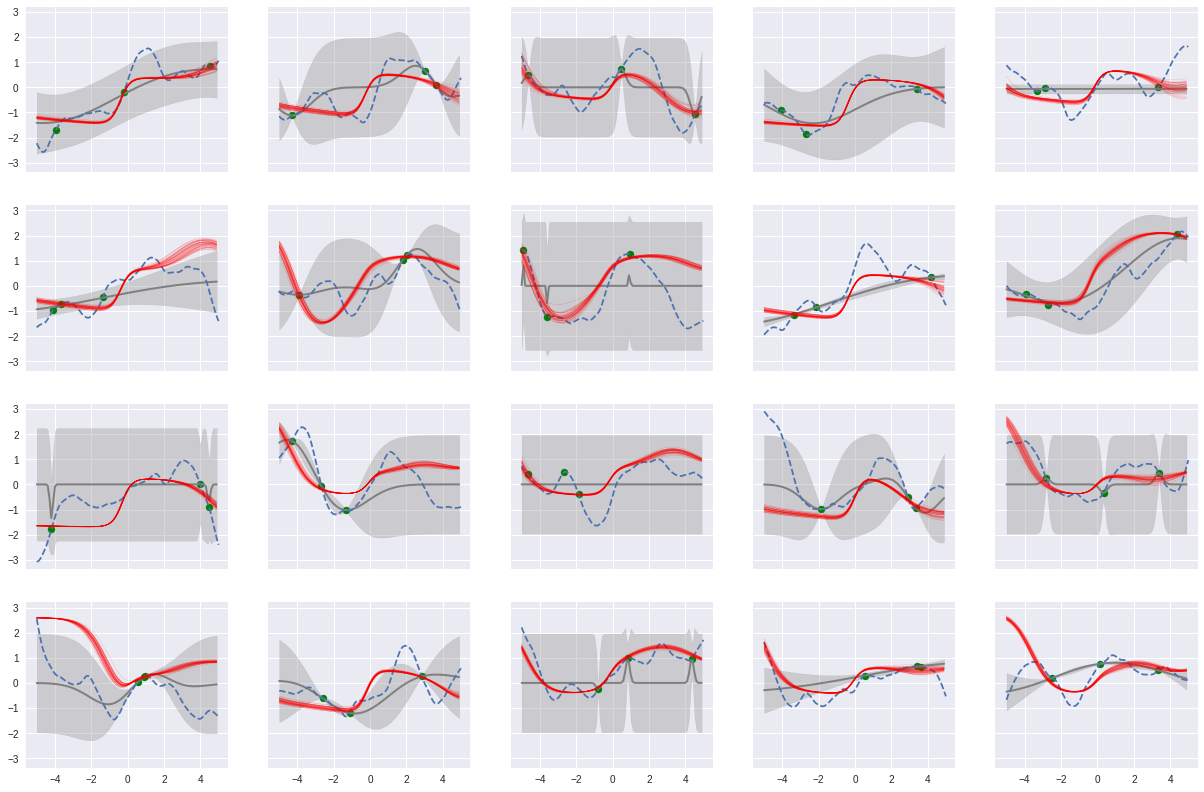

In [0]:
#@title Plot posterior samples

print("The red lines are samples from the posterior NP whereas grey curves are from a GP. \n")
print("The blue dashed line are the true underlying curve")
Image('../GP_exp2.png', width=1000)

Having a look at task 14, we see how the NP did learn the intrinsic structural information across the tasks. 


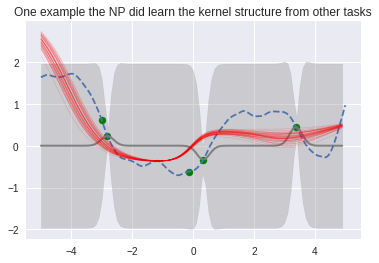

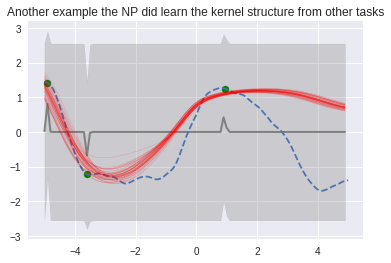

In [0]:
display(Image("../GP_exp3.png", height=300))
display(Image("../GP_exp4.png", height=300))

### Quadratic functions

The functions we consider in this section are of the form: 
$$
f(x) = xQx^{T} + p
$$
and we take $x \in \mathbb{R}\;; Q, p \in \mathbb{R}, Q > 0$. 

In [0]:
#@title Train on Quadratic Data Generator
from src.neuralprocesses import NeuralProcessParams, split_context_target
from src.neuralprocesses.network import encoder_h, decoder_g, xy_to_z_params
from src.neuralprocesses.process import init_neural_process
from src.neuralprocesses.predict import posterior_predict
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

# Set up NP parameters
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[32, 32,32], n_hidden_units_g=[32, 32, 32])

tf.reset_default_graph()
sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target,
                                     params, encoder_h, decoder_g, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

# Number of training iterations
n_iter = 1000 #@param {type:"integer"}
loss_freq = n_iter/10

train_xs = []
train_q = []
train_ys = []
train_p = []

PRINT_BOOLEAN = False #@param {type:"boolean"}
for i in range(n_iter):
    n_obs = 20
    xs = np.random.uniform(-5, 5, n_obs)
    q = random.uniform(0.001, 20)
    p = random.uniform(-10, 10)
    ys = q * (xs)**2 + p

    train_xs.append(xs)
    train_q.append(q)
    train_p.append(p)
    train_ys.append(ys)

    n_context = random.choice(range(1, 11))
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target,
                                     y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    if PRINT_BOOLEAN:
      if i % loss_freq == 0:
        print("Loss: {:.3f}".format(a[1]))

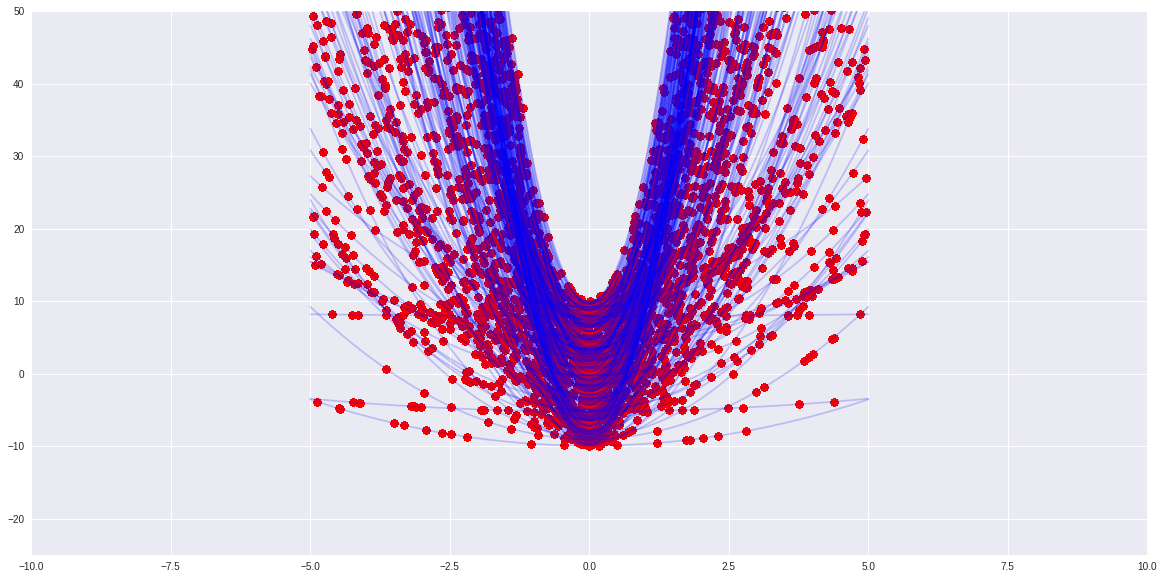

In [26]:
#@title Plot Training (Context and Target)
fig, ax = plt.subplots(1, figsize=(20,10))
n_samples = 300 #@param
x_star = np.linspace(-5, 5, 100)
for i in range(n_samples):
    y_temp = train_q[i]*x_star**2+train_p[i]
    ax.plot(x_star, y_temp, c='blue', alpha=0.2)
    ax.scatter(train_xs[:n_samples], train_ys[:n_samples], c='red', alpha=0.2)
ax.set_xlim((-10, 10))
ax.set_ylim((-25, 50))
plt.show()

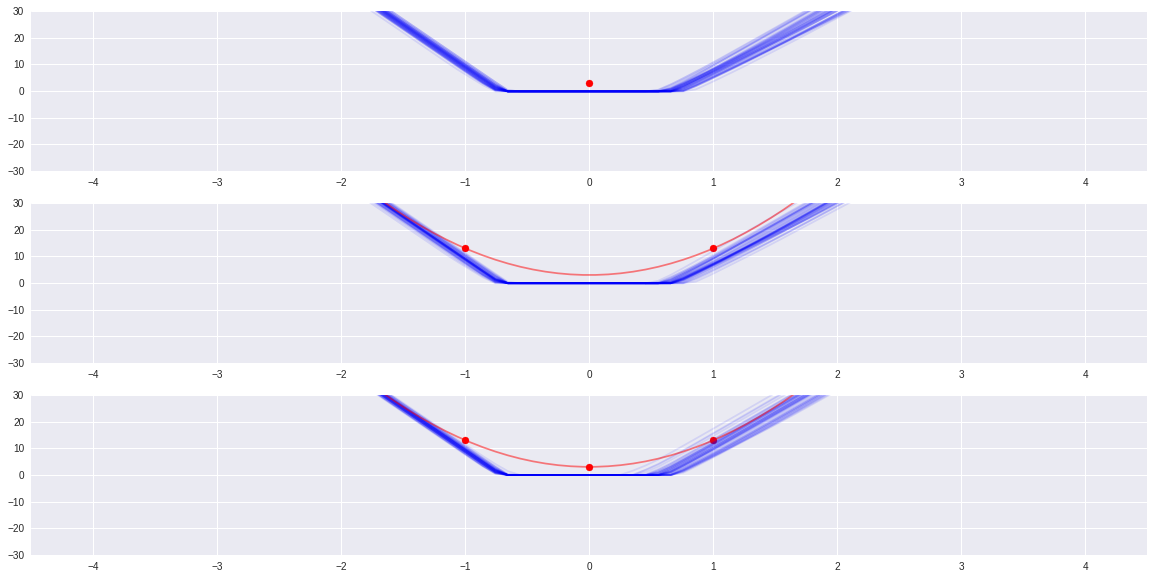

In [25]:
#@title Plot Predictions

X_SQUARED_COEFFICIENT = 10  #@param {type:"number"}
q = X_SQUARED_COEFFICIENT
Y_INTERCEPT = 0 #@param {type:"number"}
p = Y_INTERCEPT

xs = np.random.uniform(-5, 5, 5)
ys = q * (xs)**2 + p
x_star = np.linspace(-5, 5, 100)
y_star = q * (x_star)**2 + p

def plot_prediction(ax, xs, ys, x_star, y_star, plot_true = True, xlim = (-4.5, 4.5), ylim=(-1.5, 1.5), sess= tf.get_default_session()):
    posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)),
        ys.reshape((-1,1)),
        x_star.reshape((-1,1)),
        params, encoder_h, decoder_g, n_draws=50)
    y_star_mat = sess.run(posterior_predict_op.mu)

    for i in range(y_star_mat.shape[1]):
        ax.plot(x_star, y_star_mat.T[i], c='b', alpha=0.1)
    if plot_true:
        ax.plot(x_star, y_star, c='r', alpha=.5)
    ax.scatter(xs, ys, c='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, axes = plt.subplots(3, 1, figsize=(20,10))
xss = [np.array(xs) for xs in [[0], [-1, 1], [-2, -1, 0, 1, 2]]]
yss = [q * (xs)**2 + p for xs in xss]
plot_true = False
ylim=(-30, 30)
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim, sess=sess)
    plot_true = True
    ylim=(-30, 30)

plt.show()

### Polynomials

### Discussion

# Discussion